Downloading the dataset

In [ ]:
# download the dataset from kaggle if you do not have a Kaggle account, you need to create one
# Use the Kaggle public API and output a token into your local drive ("Downloads" for windows PCs)

!pip install -q kaggle
from google.colab import files
files.upload() #Upload the token file containing  the token
# create a directory named kaggle and copy kaggle.json file to kaggle directory
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# change the permission of the file
!chmod 600 ~/.kaggle/kaggle.json

# download the dataset
!kaggle datasets download -d jessicali9530/celeba-dataset

# unzip the dataset to the current directory and remove the zip file
!unzip celeba-dataset.zip -d celeba-dataset && rm celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba-dataset/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: celeba-dataset/img_align_celeba/img_

In [ ]:
!ls "/content/celeba-dataset/img_align_celeba/img_align_celeba"|wc -l

202599


In [ ]:
# Importing needed libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

R1

In [ ]:
#  read in the annotations
anno = pd.read_csv('celeba-dataset/list_attr_celeba.csv')
anno.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
anno.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [ ]:
# target only the required targets from the annotations data frame and discard the rest
anno= anno[["image_id","Smiling","Young","Male","Oval_Face"]]
anno.head()

,image_id,Smiling,Young,Male,Oval_Face
0,000001.jpg,1,1,-1,-1
1,000002.jpg,1,1,-1,-1
2,000003.jpg,-1,1,1,-1
3,000004.jpg,-1,1,-1,-1
4,000005.jpg,-1,1,-1,-1


In [ ]:
#  read in the landmarks
landmarks = pd.read_csv('celeba-dataset/list_landmarks_align_celeba.csv')
landmarks.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
0,000001.jpg,69,109,106,113,77,142,73,152,108,154
1,000002.jpg,69,110,107,112,81,135,70,151,108,153
2,000003.jpg,76,112,104,106,108,128,74,156,98,158
3,000004.jpg,72,113,108,108,101,138,71,155,101,151
4,000005.jpg,66,114,112,112,86,119,71,147,104,150


In [ ]:
# read in the partitions to discover train, validation and test segments
partition = pd.read_csv('celeba-dataset/list_eval_partition.csv')
partition.head()

,image_id,partition
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,0
3,000004.jpg,0
4,000005.jpg,0


In [ ]:
# read in the bounding boxes - these will be used to crop the images
bbox = pd.read_csv('celeba-dataset/list_bbox_celeba.csv')
bbox.head()

,image_id,x_1,y_1,width,height
0,000001.jpg,95,71,226,313
1,000002.jpg,72,94,221,306
2,000003.jpg,216,59,91,126
3,000004.jpg,622,257,564,781
4,000005.jpg,236,109,120,166


In [ ]:
# perform an outer join of the anno and bbox data frames on image_id
df1 = pd.merge(anno,bbox, on = 'image_id', how = 'outer')
df1.head()
# perform an outer join of the result with the partition data frame on image_id to obtain integrated partitions
df = pd.merge(df1,partition, on = 'image_id', how = 'outer')
df.replace(to_replace = -1, value = 0,inplace = True )
df.head()

,image_id,Smiling,Young,Male,Oval_Face,x_1,y_1,width,height,partition
0,000001.jpg,1,1,0,0,95,71,226,313,0
1,000002.jpg,1,1,0,0,72,94,221,306,0
2,000003.jpg,0,1,1,0,216,59,91,126,0
3,000004.jpg,0,1,0,0,622,257,564,781,0
4,000005.jpg,0,1,0,0,236,109,120,166,0


In [ ]:
# divide the integrated data frame into train, test and validation data frames based on the partition column 0-train, 1-test, 2-validation
train_df = df[df['partition'] == 0]
test_df = df[df['partition'] == 1]
val_df = df[df['partition'] == 2]

In [ ]:
# randomly select a fraction of images from the train dataframe
train_df = train_df.sample(frac=0.1)
train_df.head()

,image_id,Smiling,Young,Male,Oval_Face,x_1,y_1,width,height,partition
4841,004842.jpg,1,1,1,1,89,106,242,335,0
92139,092140.jpg,1,1,1,0,141,64,81,112,0
112778,112779.jpg,1,1,0,0,133,128,198,274,0
127585,127586.jpg,1,1,1,1,71,108,187,259,0
150591,150592.jpg,1,1,0,1,61,78,172,238,0


In [ ]:
# similarly select  fraction of images from the validation dataframe
val_df = val_df.sample(frac=0.1)
val_df.head()

,image_id,Smiling,Young,Male,Oval_Face,x_1,y_1,width,height,partition
190412,190413.jpg,1,1,0,0,106,92,101,162,2
194739,194740.jpg,0,1,1,1,48,45,159,220,2
197872,197873.jpg,1,0,0,0,90,31,156,216,2
200606,200607.jpg,0,0,1,0,46,65,276,382,2
191888,191889.jpg,0,1,0,1,239,154,182,252,2


In [ ]:
test_df

,image_id,Smiling,Young,Male,Oval_Face,x_1,y_1,width,height,partition
162770,162771.jpg,1,1,0,1,64,64,159,220,1
162771,162772.jpg,1,0,1,0,65,50,177,245,1
162772,162773.jpg,0,1,0,0,144,32,83,115,1
162773,162774.jpg,1,1,1,1,40,84,218,302,1
162774,162775.jpg,0,1,0,0,472,266,452,499,1
...,...,...,...,...,...,...,...,...,...,...
182632,182633.jpg,0,1,0,0,56,31,78,108,1
182633,182634.jpg,0,1,1,0,104,25,205,284,1
182634,182635.jpg,1,1,0,0,46,74,174,241,1
182635,182636.jpg,0,1,0,0,140,15,96,133,1


In [ ]:
#removing 27 number so that our test size would be divided by our batch size we use 32
rows_to_remove = test_df.sample(n=27).index
test_df = test_df.drop(rows_to_remove)
test_df

,image_id,Smiling,Young,Male,Oval_Face,x_1,y_1,width,height,partition
162770,162771.jpg,1,1,0,1,64,64,159,220,1
162771,162772.jpg,1,0,1,0,65,50,177,245,1
162772,162773.jpg,0,1,0,0,144,32,83,115,1
162773,162774.jpg,1,1,1,1,40,84,218,302,1
162774,162775.jpg,0,1,0,0,472,266,452,499,1
...,...,...,...,...,...,...,...,...,...,...
182632,182633.jpg,0,1,0,0,56,31,78,108,1
182633,182634.jpg,0,1,1,0,104,25,205,284,1
182634,182635.jpg,1,1,0,0,46,74,174,241,1
182635,182636.jpg,0,1,0,0,140,15,96,133,1


In [ ]:
# Data generator class - this is a key class that is used to batch the data so as to
# reduce compute time as well as to fit training segments into available memory
# Additionally it allows you to specify multiple targets for classification
# Also allows for image cropping

class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size=32, dim=(64,64), n_channels=3, n_classes=4, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # saves memory by batching
        df_temp = self.df.iloc[indexes]
        X, y = self.__data_generation(df_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, df_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)
        for i, row in enumerate(df_temp.values):
            img = image.load_img('celeba-dataset/img_align_celeba/img_align_celeba/' + row[0]) # extract image
            #crop the iamges using the bounding boxes
            x1 = row[5]
            y1 = row[6]
            x2 = row[5]
            y2 =row[6]
            bbox = (x1,y1,x1+x2,y1+y2)
            img=img.crop(bbox)
            #normalize the cropped and resized images
            img = img.resize(self.dim)
            img = np.array(img).astype(np.float32) / 255.0
            #specify the multiple targets now into your y vector
            X[i]=img
            y[i]=[row[1],row[2],row[3],row[4]]


        return X, y

In [ ]:
# using vgg16 as feature extractor - this is a simpler, but equally eefective
# here we are freezing the VGG16 for first 12 layers and making trainable for last 4 layers
vgg16 = tf.keras.applications.VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
for layer in vgg16.layers[:-4]:
  layer.trainable = False

In [ ]:
from keras.layers import Dense,Flatten, Dropout
# creating the model
model = tf.keras.Sequential([
    vgg16])
    # flatten the top 15 layers into one single layer containing the weights learned
    # in the first 15 layers of vgg16
model.add(Flatten())

    # add a dense layer for classification
model.add(Dense(4096,activation = 'relu'))
model.add(Dense(2048,activation = 'relu'))
model.add(Dropout(0.2))


    # now specify the number of neurons in the output layer with the appropriate number of output neurons
model.add(Dense(4, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_7 (Dense)             (None, 4096)              8392704   
                                                                 
 dense_8 (Dense)             (None, 2048)              8390656   
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_9 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 31,506,244
Trainable params: 23,870,980


In [ ]:
# compiling the model
model.compile(optimizer=SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# creating the train, test and validation data generators
train_generator = DataGenerator(train_df, batch_size=32, dim=(64,64), n_channels=3, n_classes=4, shuffle=True)
test_generator = DataGenerator(test_df, batch_size=32, dim=(64,64), n_channels=3, n_classes=4, shuffle=True)
val_generator = DataGenerator(val_df, batch_size=32, dim=(64,64), n_channels=3, n_classes=4, shuffle=True)

In [ ]:
# training the model
history = model.fit(train_generator, epochs=5, validation_data=val_generator)

Epoch 1/5
508/508 [==============================] - 31s 59ms/step - loss: 0.6456 - accuracy: 0.3752 - val_loss: 0.6300 - val_accuracy: 0.3936
Epoch 2/5
508/508 [==============================] - 29s 56ms/step - loss: 0.6214 - accuracy: 0.4099 - val_loss: 0.6270 - val_accuracy: 0.3936
Epoch 3/5
508/508 [==============================] - 29s 57ms/step - loss: 0.6180 - accuracy: 0.4096 - val_loss: 0.6245 - val_accuracy: 0.3952
Epoch 4/5
508/508 [==============================] - 31s 61ms/step - loss: 0.6160 - accuracy: 0.4098 - val_loss: 0.6232 - val_accuracy: 0.3942
Epoch 5/5
508/508 [==============================] - 28s 56ms/step - loss: 0.6144 - accuracy: 0.4096 - val_loss: 0.6217 - val_accuracy: 0.3942


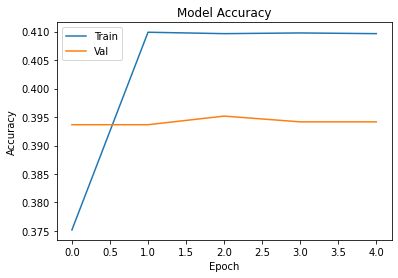

In [ ]:
# plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
y_pred=model.predict(test_generator)
y_pred=np.round(y_pred)
y_pred


620/620 [==============================] - 29s 47ms/step


array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 1., 1., 0.],
       ...,
       [1., 1., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [ ]:
len(y_pred)

19840

In [ ]:
#getting accuracy score for test data
from sklearn.metrics import accuracy_score
y_true=test_df[["Smiling","Young","Male","Oval_Face"]]

accuracy= accuracy_score(y_true,y_pred)
print(accuracy)

0.15630040322580646


In [ ]:

y_true = np.array(y_true)
y_true

array([[1, 1, 0, 1],
       [1, 0, 1, 0],
       [0, 1, 0, 0],
       ...,
       [1, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 1, 0]])

In [ ]:
#hamming score looks every correct prediction for each level and it is ratio of each correct prediction to the total preddiction
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):

    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []

    for i in range(y_true.shape[0]):

        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )

        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))

        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred)) /   float(len(set_true.union(set_pred)))

        #print('tmp_a: {0}'.format(tmp_a))

        acc_list.append(tmp_a)

    return np.mean(acc_list)



In [ ]:
print('Hamming score: {0}'.format(hamming_score(y_true, y_pred)))

Hamming score: 0.444695060483871


Using mouth width difference for classifying smiling or not

In [ ]:
# pre-process the landmarks file and compute mouth width
landmarks['mouth_width']=landmarks['rightmouth_x']-landmarks['leftmouth_x']
# normalize
landmarks['mouth_width'] = (landmarks['mouth_width'] - landmarks['mouth_width'].min()) / (landmarks['mouth_width'].max() - landmarks['mouth_width'].min())
#bin
landmarks['mouth_width_binned'] = pd.qcut(landmarks['mouth_width'], q=2, labels=[-1, 1])
landmarks.head()

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,mouth_width,mouth_width_binned
0,000001.jpg,69,109,106,113,77,142,73,152,108,154,0.557377,1
1,000002.jpg,69,110,107,112,81,135,70,151,108,153,0.606557,1
2,000003.jpg,76,112,104,106,108,128,74,156,98,158,0.377049,-1
3,000004.jpg,72,113,108,108,101,138,71,155,101,151,0.475410,-1
4,000005.jpg,66,114,112,112,86,119,71,147,104,150,0.524590,-1


In [ ]:
landmarks.loc[landmarks['mouth_width_binned'] == 1]

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,mouth_width,mouth_width_binned
0,000001.jpg,69,109,106,113,77,142,73,152,108,154,0.557377,1
1,000002.jpg,69,110,107,112,81,135,70,151,108,153,0.606557,1
8,000009.jpg,68,113,110,111,97,139,66,152,109,150,0.688525,1
9,000010.jpg,68,111,108,112,89,136,70,151,107,151,0.590164,1
11,000012.jpg,69,112,108,112,89,136,68,150,109,152,0.655738,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202591,202592.jpg,67,111,110,113,85,134,67,149,112,151,0.721311,1
202592,202593.jpg,68,112,109,112,86,141,69,151,107,152,0.606557,1
202595,202596.jpg,67,112,110,112,85,141,66,150,110,150,0.704918,1
202596,202597.jpg,69,111,107,111,92,137,68,151,109,153,0.655738,1


In [ ]:
landmarks.loc[landmarks['mouth_width_binned'] == -1]

,image_id,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,mouth_width,mouth_width_binned
2,000003.jpg,76,112,104,106,108,128,74,156,98,158,0.377049,-1
3,000004.jpg,72,113,108,108,101,138,71,155,101,151,0.475410,-1
4,000005.jpg,66,114,112,112,86,119,71,147,104,150,0.524590,-1
5,000006.jpg,71,111,106,110,94,131,74,154,102,153,0.442623,-1
6,000007.jpg,70,112,108,111,85,135,72,152,104,152,0.508197,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
202587,202588.jpg,69,112,109,111,86,131,71,151,105,151,0.540984,-1
202589,202590.jpg,69,111,108,112,89,134,73,152,104,152,0.491803,-1
202593,202594.jpg,69,111,108,111,91,139,74,153,103,151,0.459016,-1
202594,202595.jpg,69,111,108,111,89,140,73,151,104,153,0.491803,-1


In [ ]:
# integrate the new version of the landmarks data frame with the annotations, bounding box and partitions
# data frames, just as you did before
landmarks1=landmarks[['image_id','mouth_width_binned']]
landmarks1.head()
df2 = pd.merge(anno,bbox, on = 'image_id', how = 'outer')
df3=pd.merge(df2,partition,on ='image_id', how = 'outer')
df=pd.merge(df3,landmarks1,on='image_id',how = 'outer')

df.head()



,image_id,Smiling,Young,Male,Oval_Face,x_1,y_1,width,height,partition,mouth_width_binned
0,000001.jpg,1,1,-1,-1,95,71,226,313,0,1
1,000002.jpg,1,1,-1,-1,72,94,221,306,0,1
2,000003.jpg,-1,1,1,-1,216,59,91,126,0,-1
3,000004.jpg,-1,1,-1,-1,622,257,564,781,0,-1
4,000005.jpg,-1,1,-1,-1,236,109,120,166,0,-1


In [ ]:
df.replace(to_replace = -1, value = 0,inplace = True )
df.head()

,image_id,Smiling,Young,Male,Oval_Face,x_1,y_1,width,height,partition,mouth_width_binned
0,000001.jpg,1,1,0,0,95,71,226,313,0,1
1,000002.jpg,1,1,0,0,72,94,221,306,0,1
2,000003.jpg,0,1,1,0,216,59,91,126,0,0
3,000004.jpg,0,1,0,0,622,257,564,781,0,0
4,000005.jpg,0,1,0,0,236,109,120,166,0,0


R3

In [ ]:
# divide the integrated data frame into train, test and validation data frames based on the partition column 0-train, 1-test, 2-validation
train_df = df[df['partition'] == 0]
test_df = df[df['partition'] == 1]
val_df = df[df['partition'] == 2]

In [ ]:
train_df = train_df.sample(frac=0.1)
val_df = val_df.sample(frac=0.1)
val_df.head()


,image_id,Smiling,Young,Male,Oval_Face,x_1,y_1,width,height,partition,mouth_width_binned
193851,193852.jpg,1,1,0,1,228,41,213,295,2,1
201717,201718.jpg,0,1,1,0,199,72,346,479,2,0
199240,199241.jpg,1,1,0,0,333,149,135,187,2,1
196580,196581.jpg,0,1,0,0,362,65,242,335,2,0
197615,197616.jpg,0,0,0,0,119,40,174,241,2,0


In [ ]:
rows_to_remove = test_df.sample(n=27).index
test_df = test_df.drop(rows_to_remove)
test_df

,image_id,Smiling,Young,Male,Oval_Face,x_1,y_1,width,height,partition,mouth_width_binned
162770,162771.jpg,1,1,0,1,64,64,159,220,1,0
162771,162772.jpg,1,0,1,0,65,50,177,245,1,1
162772,162773.jpg,0,1,0,0,144,32,83,115,1,0
162773,162774.jpg,1,1,1,1,40,84,218,302,1,1
162774,162775.jpg,0,1,0,0,472,266,452,499,1,0
...,...,...,...,...,...,...,...,...,...,...,...
182632,182633.jpg,0,1,0,0,56,31,78,108,1,0
182633,182634.jpg,0,1,1,0,104,25,205,284,1,0
182634,182635.jpg,1,1,0,0,46,74,174,241,1,1
182635,182636.jpg,0,1,0,0,140,15,96,133,1,0


In [ ]:
# modify your Data Generator class to handle your new targets
class DataGenerator1(tf.keras.utils.Sequence):

    def __init__(self, df, batch_size=32, dim=(64,64), n_channels=3, n_classes=4, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df = df
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # saves memory by batching
        df_temp = self.df.iloc[indexes]
        X, y = self.__data_generation(df_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, df_temp):
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)
        for i, row in enumerate(df_temp.values):
            img = image.load_img('celeba-dataset/img_align_celeba/img_align_celeba/' + row[0]) # extract image
            #crop the iamges using the bounding boxes
            x1 = row[5]
            y1 = row[6]
            x2 = row[5]+row[7]
            y2 =row[6]+row[8]
            bbox = (x1,y1,x2,y2)
            img=img.crop(bbox)
            #normalize the cropped and resized images
            img = img.resize(self.dim)
            img = np.array(img).astype(np.float32) / 255.0
            #specify the multiple targets now into your y vector
            X[i]=img
            y[i]=[row[2],row[3],row[4],row[10]]


        return X, y


In [ ]:
# using vgg16 as feature extractor - this is a simpler, but equally eefective
# version of the code used for the Dogs vs Cats example
vgg16 = tf.keras.applications.VGG16(input_shape=(64, 64, 3), include_top=False, weights='imagenet')
for layer in vgg16.layers[:-2]:
  layer.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
from keras.layers import Dense,Flatten, Dropout
# creating the model
model1 = tf.keras.Sequential([
    vgg16])
    # flatten the top 15 layers into one single layer containing the weights learned
    # in the first 15 layers of vgg16
model1.add(Flatten())

    # add a dense layer for classification
model1.add(Dense(4096,activation = 'relu'))
model1.add(Dense(2048,activation = 'relu'))
model1.add(Dropout(0.2))

    # now specify the number of neurons in the output layer with the appropriate number of output neurons
model1.add(Dense(4, activation='sigmoid'))

In [ ]:
# compiling the model
model1.compile(optimizer=SGD(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# creating the train, test and validation data generators
train_generator1 = DataGenerator1(train_df, batch_size=32, dim=(64,64), n_channels=3, n_classes=4, shuffle=True)
test_generator1 = DataGenerator1(test_df, batch_size=32, dim=(64,64), n_channels=3, n_classes=4, shuffle=True)
val_generator1 = DataGenerator1(val_df, batch_size=32, dim=(64,64), n_channels=3, n_classes=4, shuffle=True)

In [ ]:
# training the model
history = model1.fit(train_generator1, epochs=5, validation_data=val_generator1)

Epoch 1/5
508/508 [==============================] - 54s 84ms/step - loss: 0.6440 - accuracy: 0.7604 - val_loss: 0.6319 - val_accuracy: 0.7918
Epoch 2/5
508/508 [==============================] - 42s 83ms/step - loss: 0.6271 - accuracy: 0.7996 - val_loss: 0.6283 - val_accuracy: 0.7913
Epoch 3/5
508/508 [==============================] - 43s 84ms/step - loss: 0.6240 - accuracy: 0.7995 - val_loss: 0.6251 - val_accuracy: 0.7918
Epoch 4/5
508/508 [==============================] - 41s 81ms/step - loss: 0.6208 - accuracy: 0.7998 - val_loss: 0.6226 - val_accuracy: 0.7913
Epoch 5/5
508/508 [==============================] - 41s 80ms/step - loss: 0.6182 - accuracy: 0.7997 - val_loss: 0.6205 - val_accuracy: 0.7913


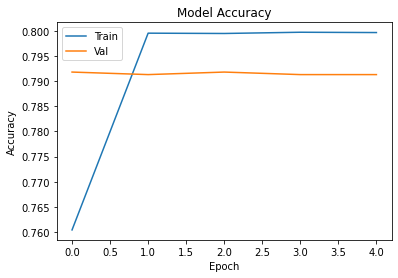

In [ ]:
# plotting the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
#predicting the y vector values for out test data
y_pred1=model1.predict(test_generator1)
y_pred1


620/620 [==============================] - 44s 70ms/step


array([[0.7909319 , 0.35834983, 0.22388822, 0.41290185],
       [0.74647975, 0.4382421 , 0.30115613, 0.48321554],
       [0.7651455 , 0.39987323, 0.31137368, 0.46361688],
       ...,
       [0.7909319 , 0.35834983, 0.22388822, 0.41290185],
       [0.7814652 , 0.41555348, 0.3026411 , 0.42948943],
       [0.7828934 , 0.47300854, 0.30331948, 0.49700505]], dtype=float32)

In [ ]:
y_pred1=np.round(y_pred1)
y_pred1

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [ ]:
# Getting accuracy score for test data
from sklearn.metrics import accuracy_score
y_true1=test_df[["Young","Male","Oval_Face","mouth_width_binned"]]

accuracy= accuracy_score(y_true1,y_pred1)
print(accuracy)

0.17162298387096775


In [ ]:
# getting hamming score which gives us the partial accuracy of the test data
y_true1 = np.array(y_true1)

print('Hamming score: {0}'.format(hamming_score(y_true1, y_pred1)))

Hamming score: 0.47941028225806454


R4

In [ ]:
'''
The training accuracy of R3 is 79.13% and the training accuracy of R1 is 39.42% which is a great improvement once we replaced Smiling with Mouth Width.
But coming to the test dataset, R3's accuracy is 17.16% and R1's accuracy is 16.24%. There is only a minimal increase in test accuracy. Even though the improvement was not significant, we can still say that using Mouth Width instead of Smiling is better.
 This is a multilabel classification problem and the prediction is considered correct only if all the 4 predicted classes are correct. So, there might be cases when the model would predict 3 classes correct and one class wrong resulting in a false prediction. Therefore, we also considered checking Hamming score on R1 and R3 to compare the similarity of the predicted and true labels.
Hamming accuracy of R1 is 44.46% and for R4 its 47.94%
'''